<a href="https://colab.research.google.com/github/Irushai/DS-final-project/blob/main/DS_project_Irina%26IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **1. DS Project with Claude AI**:  
This project is inspired by a research that explores how Siamese neural networks can be used to assess damage to buildings. Here are some potential ways to improve and expand upon the ideas of that  project:

**1. Enhanced Architecture Exploration:**


*   Try more recent backbone architectures like EfficientNetV2, RegNet, or ConvNeXt that might offer better performance
*   Experiment with Vision Transformers (ViT) or hybrid CNN-Transformer models which could excel at capturing spatial relationships in satellite imagery

*   Implement attention mechanisms specifically designed for change detection

**2. Data Fusion Techniques:**

Instead of just concatenation or subtraction of feature maps, explore more sophisticated fusion techniques:
*   Cross-attention mechanisms between pre and post-disaster images
*   Gated fusion networks

*   Feature correlation layers like those used in optical flow estimation


**3. Loss Function Improvements:**


*   Implement Focal Loss to better handle class imbalance
*   Try Dice or Lovász loss which often work well for segmentation tasks

*   Explore compound losses that combine classification and segmentation objectives
*   Add boundary-aware terms to improve building delineation


**4. Post-processing Enhancements:**


*   Implement Conditional Random Fields (CRF) for more coherent predictions
*  Use morphological operations to refine building boundaries
*   Apply instance-level processing to ensure consistent damage classification within each building


**5. Data Augmentation Expansions:**
*   Implement more disaster-specific augmentations that simulate real-world conditions
*   Use style transfer to generate synthetic disaster effects
*   Create physics-based simulations of different damage types


**6. Multi-task Learning Approach:**
*   Train the network to simultaneously predict building footprints, damage classification, and perhaps disaster type
*  Add auxiliary tasks like edge detection or distance transform prediction

**7. Temporal Extensions:**
*   Modify the architecture to handle more than two timestamps
*   Incorporate temporal consistency constraints when multiple post-disaster images are available


**8. External Data Integration:**
*  Incorporate additional modalities like SAR (Synthetic Aperture Radar) data which works even with cloud cover
Use DEM (Digital Elevation Models) to provide height information
*   Add contextual information like building type, age, or materials from GIS databases


**9. Explainability Components:**
*   Add visualization methods to highlight which parts of the buildings contributed most to the damage assessment
*   Implement GradCAM or similar techniques to understand model decisions
*   Create confidence metrics for predictions

**10. Deployment Optimizations:**
*   Quantize models for faster inference
*   Implement sliding window techniques for very large satellite images
*   Design a lightweight version for edge deployment in disaster zones





After looking at the different possibilities, it seems that using ***cross-attention mechanisms between the images taken before and after a disaster*** could lead to the biggest improvement in how the system works now. This method should help the model better see and pay attention to the key differences in the images, which is essential for correctly judging the damage.

This improved implementation adds cross-attention mechanisms to the Siamese network architecture, which should significantly enhance the model's ability to detect and classify building damage. Here's what makes this implementation powerful:

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet34, ResNet34_Weights


class CrossAttention(nn.Module):
    """
    Cross-attention module to help the model focus on relevant changes
    between pre and post disaster images.
    """
    def __init__(self, in_channels):
        super(CrossAttention, self).__init__()
        self.query_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, pre_features, post_features):
        """
        inputs:
            pre_features: features from pre-disaster image [B, C, H, W]
            post_features: features from post-disaster image [B, C, H, W]
        """
        batch_size, C, height, width = pre_features.size()

        # Pre features generate queries
        proj_query = self.query_conv(pre_features).view(batch_size, -1, height * width).permute(0, 2, 1)

        # Post features generate keys
        proj_key = self.key_conv(post_features).view(batch_size, -1, height * width)

        # Attention map
        energy = torch.bmm(proj_query, proj_key)
        attention = self.softmax(energy)

        # Post features generate values
        proj_value = self.value_conv(post_features).view(batch_size, -1, height * width)

        # Apply attention to values
        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, height, width)

        # Residual connection with pre_features
        out = self.gamma * out + pre_features

        return out


class DecoderBlock(nn.Module):
    """
    Decoder block for Unet-like architecture
    """
    def __init__(self, in_channels, middle_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.decode = nn.Sequential(
            nn.Conv2d(in_channels, middle_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(middle_channels, middle_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.decode(x)


class SiameseNetworkWithCrossAttention(nn.Module):
    """
    Siamese Network with Cross-Attention for building damage assessment
    """
    def __init__(self, num_classes=5, pretrained=True):
        super(SiameseNetworkWithCrossAttention, self).__init__()

        # Load pretrained ResNet34 backbone
        weights = ResNet34_Weights.DEFAULT if pretrained else None
        encoder = resnet34(weights=weights)

        # Define encoder stages
        self.enc1 = nn.Sequential(encoder.conv1, encoder.bn1, encoder.relu)  # 64 channels
        self.enc2 = nn.Sequential(encoder.maxpool, encoder.layer1)           # 64 channels
        self.enc3 = encoder.layer2                                           # 128 channels
        self.enc4 = encoder.layer3                                           # 256 channels
        self.enc5 = encoder.layer4                                           # 512 channels

        # Cross-attention modules
        self.ca1 = CrossAttention(64)
        self.ca2 = CrossAttention(64)
        self.ca3 = CrossAttention(128)
        self.ca4 = CrossAttention(256)
        self.ca5 = CrossAttention(512)

        # Decoder stages with skip connections
        self.dec5 = DecoderBlock(512, 512, 256)
        self.dec4 = DecoderBlock(512, 256, 128)
        self.dec3 = DecoderBlock(256, 128, 64)
        self.dec2 = DecoderBlock(128, 64, 64)
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        # Final classification layer
        self.final = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, pre_img, post_img):
        """
        Forward pass with pre and post disaster images
        Args:
            pre_img: pre-disaster image [B, 3, H, W]
            post_img: post-disaster image [B, 3, H, W]
        """
        # Encode pre-disaster image
        pre_enc1 = self.enc1(pre_img)                 # [B, 64, H/2, W/2]
        pre_enc2 = self.enc2(pre_enc1)                # [B, 64, H/4, W/4]
        pre_enc3 = self.enc3(pre_enc2)                # [B, 128, H/8, W/8]
        pre_enc4 = self.enc4(pre_enc3)                # [B, 256, H/16, W/16]
        pre_enc5 = self.enc5(pre_enc4)                # [B, 512, H/32, W/32]

        # Encode post-disaster image
        post_enc1 = self.enc1(post_img)               # [B, 64, H/2, W/2]
        post_enc2 = self.enc2(post_enc1)              # [B, 64, H/4, W/4]
        post_enc3 = self.enc3(post_enc2)              # [B, 128, H/8, W/8]
        post_enc4 = self.enc4(post_enc3)              # [B, 256, H/16, W/16]
        post_enc5 = self.enc5(post_enc4)              # [B, 512, H/32, W/32]

        # Apply cross-attention at each level
        ca_enc1 = self.ca1(pre_enc1, post_enc1)
        ca_enc2 = self.ca2(pre_enc2, post_enc2)
        ca_enc3 = self.ca3(pre_enc3, post_enc3)
        ca_enc4 = self.ca4(pre_enc4, post_enc4)
        ca_enc5 = self.ca5(pre_enc5, post_enc5)

        # Decode with skip connections
        dec5 = self.dec5(ca_enc5)                                      # [B, 256, H/16, W/16]
        dec4 = self.dec4(torch.cat([dec5, ca_enc4], dim=1))            # [B, 128, H/8, W/8]
        dec3 = self.dec3(torch.cat([dec4, ca_enc3], dim=1))            # [B, 64, H/4, W/4]
        dec2 = self.dec2(torch.cat([dec3, ca_enc2], dim=1))            # [B, 64, H/2, W/2]
        dec1 = self.dec1(torch.cat([dec2, ca_enc1], dim=1))            # [B, 64, H/2, W/2]

        # Final classification
        outputs = self.final(dec1)                                     # [B, num_classes, H/2, W/2]

        # Upscale to original image size
        outputs = F.interpolate(outputs, size=pre_img.shape[2:], mode='bilinear', align_corners=False)

        return outputs


# Focal Loss to handle class imbalance better
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, weight=None, ignore_index=255):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.weight = weight
        self.ignore_index = ignore_index
        self.ce_fn = nn.CrossEntropyLoss(weight=self.weight, ignore_index=self.ignore_index)

    def forward(self, preds, labels):
        logpt = -self.ce_fn(preds, labels)
        pt = torch.exp(logpt)
        loss = -((1 - pt) ** self.gamma) * self.alpha * logpt
        return loss


# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=100, device='cuda'):
    """
    Training loop for the model
    """
    best_score = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for batch_idx, (pre_imgs, post_imgs, targets) in enumerate(train_loader):
            pre_imgs = pre_imgs.to(device)
            post_imgs = post_imgs.to(device)
            targets = targets.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            outputs = model(pre_imgs, post_imgs)
            loss = criterion(outputs, targets)

            # Backward + optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if batch_idx % 20 == 19:
                print(f'Epoch: {epoch+1}/{num_epochs}, Batch: {batch_idx+1}, Loss: {running_loss/20:.4f}')
                running_loss = 0.0

        # Validate after each epoch
        val_score = validate_model(model, val_loader, device)
        print(f'Epoch: {epoch+1}/{num_epochs}, Validation F1 Score: {val_score:.4f}')

        # Save best model
        if val_score > best_score:
            best_score = val_score
            torch.save(model.state_dict(), 'best_model.pth')

        # Update learning rate
        scheduler.step()

    return model


# Validation function to calculate F1 score
def validate_model(model, val_loader, device='cuda'):
    """
    Validation function that calculates F1 scores for building localization and damage classification
    """
    model.eval()

    # Initialize metrics
    tp_loc, fp_loc, fn_loc = 0, 0, 0
    tp_class, fp_class, fn_class = 0, 0, 0

    with torch.no_grad():
        for pre_imgs, post_imgs, targets in val_loader:
            pre_imgs = pre_imgs.to(device)
            post_imgs = post_imgs.to(device)
            targets = targets.to(device)

            outputs = model(pre_imgs, post_imgs)
            preds = torch.argmax(outputs, dim=1)

            # Building localization (any class > 0 is a building)
            pred_buildings = (preds > 0)
            target_buildings = (targets > 0)

            tp_loc += torch.logical_and(pred_buildings, target_buildings).sum().item()
            fp_loc += torch.logical_and(pred_buildings, ~target_buildings).sum().item()
            fn_loc += torch.logical_and(~pred_buildings, target_buildings).sum().item()

            # Damage classification (only for correctly detected buildings)
            building_mask = (targets > 0)
            correct_buildings = torch.logical_and(pred_buildings, target_buildings)

            for c in range(1, 5):  # Damage classes (1-4)
                pred_c = (preds == c)
                target_c = (targets == c)

                tp_class += torch.logical_and(pred_c, target_c).sum().item()
                fp_class += torch.logical_and(pred_c, ~target_c).sum().item()
                fn_class += torch.logical_and(~pred_c, target_c).sum().item()

    # Calculate F1 scores
    precision_loc = tp_loc / (tp_loc + fp_loc + 1e-8)
    recall_loc = tp_loc / (tp_loc + fn_loc + 1e-8)
    f1_loc = 2 * precision_loc * recall_loc / (precision_loc + recall_loc + 1e-8)

    precision_class = tp_class / (tp_class + fp_class + 1e-8)
    recall_class = tp_class / (tp_class + fn_class + 1e-8)
    f1_class = 2 * precision_class * recall_class / (precision_class + recall_class + 1e-8)

    # Calculate weighted score (0.3*F1_loc + 0.7*F1_class)
    weighted_score = 0.3 * f1_loc + 0.7 * f1_class

    return weighted_score


# Example of how to use the model
def main():
    # Initialize model
    model = SiameseNetworkWithCrossAttention(num_classes=5)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Define loss function with class weights to handle imbalance
    class_weights = torch.tensor([1.0, 1.0, 3.0, 3.0, 3.0], device=device)
    criterion = FocalLoss(weight=class_weights)

    # Define optimizer and scheduler
    optimizer = torch.optim.RAdam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-6)

    # Train and validate (assuming you have data loaders)
    # train_model(model, train_loader, val_loader, criterion, optimizer, scheduler)

    print("Model training code is ready to be executed with your data loaders.")


if __name__ == "__main__":
    main()

### **Key Improvements:**



1.  **Cross-Attention Mechanism:**


*   The model now uses queries from pre-disaster features and keys/values from post-disaster features
*   This helps the network focus on relevant changes between the images
*   The attention is applied at multiple levels of the encoder, allowing multi-scale change detection


2.   **Enhanced Loss Function:**


*   Implemented Focal Loss instead of weighted Cross-Entropy
*  Cross-Entropy
Better handles class imbalance by focusing more on hard examples and less on easy ones
*  Maintains the class weighting to prioritize under-represented damage classes


3. **ResNet34 Backbone with Skip Connections:**

*  Uses a proven encoder with pretrained weights
*  Detailed skip connections ensure high-resolution feature preservation
*  Maintains spatial information critical for accurate building segmentation

4. **Comprehensive Training and Validation Functions:**

*   Includes complete training loop with learning rate scheduling
*   Validation function calculates the competition-specific weighted F1 scores
*   Best model checkpointing based on validation performance







### **Usage**

To use this model, you would:


1.   Prepare your data loaders for the xBD dataset
2.   Initialize the model, loss function, optimizer, and scheduler
3.   Run the training loop, which handles both training and validation
4. Load the best model for inference



The cross-attention mechanism should provide better focus on the changes between pre and post-disaster images, leading to more accurate damage classification while maintaining good building localization performance.


## **2. DS Project with ChatGPT**

## 🚀 **Hybrid Model: EfficientNet Encoder + U-Net Decoder for Building Damage Assessment**

This solution uses EfficientNet as the encoder and U-Net as the decoder to perform satellite image segmentation for building damage assessment. The implementation is done in PyTorch using the segmentation_models_pytorch (SMP) library.

## 📌 Setup: Install Dependencies
Make sure you have the required libraries installed:

In [1]:
!pip install torch torchvision albumentations timm fastai segmentation-models-pytorch


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## 📜 train.py — Training Script

This script:


*   Loads and preprocesses satellite images

*  Defines the EfficientNet + U-Net model
*   Trains the model with logging

* Saves model weights after every 5 epochs




In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import os
import numpy as np
from tqdm import tqdm

# ==========================
# 1. CONFIGURATION
# ==========================
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
ENCODER = 'efficientnet-b4'  # Choose EfficientNet version (b0-b7)
ENCODER_WEIGHTS = 'imagenet'
BATCH_SIZE = 4
EPOCHS = 20
LEARNING_RATE = 1e-4
IMG_SIZE = 256  # Image size
DATASET_PATH = "dataset/"  # Path to dataset

# ==========================
# 2. CUSTOM DATASET
# ==========================
class xView2Dataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images = sorted(os.listdir(images_dir))
        self.masks = sorted(os.listdir(masks_dir))
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])
        mask_path = os.path.join(self.masks_dir, self.masks[idx])

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image, mask = augmented["image"], augmented["mask"]

        return image, mask

# ==========================
# 3. DATA AUGMENTATION
# ==========================
transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

train_dataset = xView2Dataset(DATASET_PATH + "train/images", DATASET_PATH + "train/masks", transform=transform)
val_dataset = xView2Dataset(DATASET_PATH + "val/images", DATASET_PATH + "val/masks", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ==========================
# 4. MODEL CREATION
# ==========================
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    in_channels=3,
    classes=1,  # Binary segmentation
)

model = model.to(DEVICE)

# ==========================
# 5. TRAINING LOOP
# ==========================
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

def train(model, train_loader, val_loader, epochs):
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for images, masks in tqdm(train_loader):
            images, masks = images.to(DEVICE), masks.to(DEVICE, dtype=torch.float32)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks.unsqueeze(1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss / len(train_loader)}")

        # Save model every 5 epochs
        if (epoch + 1) % 5 == 0:
            torch.save(model.state_dict(), f"model_epoch_{epoch+1}.pth")

train(model, train_loader, val_loader, EPOCHS)


## 📜 inference.py — Inference Script

This script:


*   Loads a trained EfficientNet + U-Net model

*   Performs segmentation on test satellite images
*   Saves predicted damage masks



In [ ]:
import torch
import segmentation_models_pytorch as smp
import cv2
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os

# ==========================
# 1. CONFIGURATION
# ==========================
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
MODEL_PATH = "model_epoch_20.pth"  # Path to trained model
ENCODER = 'efficientnet-b4'
ENCODER_WEIGHTS = None
IMG_SIZE = 256
INPUT_DIR = "dataset/test/images/"
OUTPUT_DIR = "dataset/test/predictions/"

# ==========================
# 2. LOAD TRAINED MODEL
# ==========================
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    in_channels=3,
    classes=1
)

model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model = model.to(DEVICE)
model.eval()

# ==========================
# 3. IMAGE PREPROCESSING
# ==========================
transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

# ==========================
# 4. INFERENCE FUNCTION
# ==========================
def predict(image_path, model):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    augmented = transform(image=image)
    image = augmented["image"].unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        output = model(image)
        output = torch.sigmoid(output).cpu().numpy()[0, 0]

    return output

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

for img_name in os.listdir(INPUT_DIR):
    img_path = os.path.join(INPUT_DIR, img_name)
    mask = predict(img_path, model)

    output_path = os.path.join(OUTPUT_DIR, img_name)
    cv2.imwrite(output_path, (mask * 255).astype(np.uint8))

print("✅ Inference completed! Masks saved in:", OUTPUT_DIR)


## 🎯 How to Use


1.  **Train the model:**
Run train.py to train the EfficientNet + U-Net model on xView2 dataset.
2.   **Save trained weights:**
The script automatically saves weights (model_epoch_20.pth).
3. **Run inference:**
Update the model path in inference.py and run it to generate segmentation masks.



## 💡 Summary


*   EfficientNet as Encoder + U-Net as Decoder
*   Binary segmentation for building damage assessment

*  Preprocessing using Albumentations
*  Trained using BCEWithLogitsLoss & Adam Optimizer
*  Inference on new images with mask predictions saved



This provides a robust deep learning solution for satellite image-based damage assessment using state-of-the-art models. 🚀

## 📂 Step 1: Load the Dataset. Explore the Data Structure
We will use the xView2 dataset, which contains satellite images with building masks.

1️⃣ Download the dataset (or upload your own):

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from google.colab import files
uploaded = files.upload()

Total number of images: 1866
Total number of label files: 1866
Total number of target files: 1866
Target image sizes: {(1024, 1024)}
Number of unique pixel values: [2, 1, 4, 1, 2, 1, 2, 3, 1, 5, 3, 3, 1, 2, 1, 2, 1, 2, 2, 2]

=== Dataset Summary ===
Total images: 1866
Disaster types: midwest-flooding, palu-tsunami, santa-rosa-wildfire, socal-fire, hurricane-michael, guatemala-volcano, hurricane-florence, hurricane-harvey, hurricane-matthew, mexico-earthquake
Phase distribution: {'pre': 933, 'post': 933}
Damage types: major-damage, no-damage, destroyed, un-classified, minor-damage
Feature types: {'building': 3632}


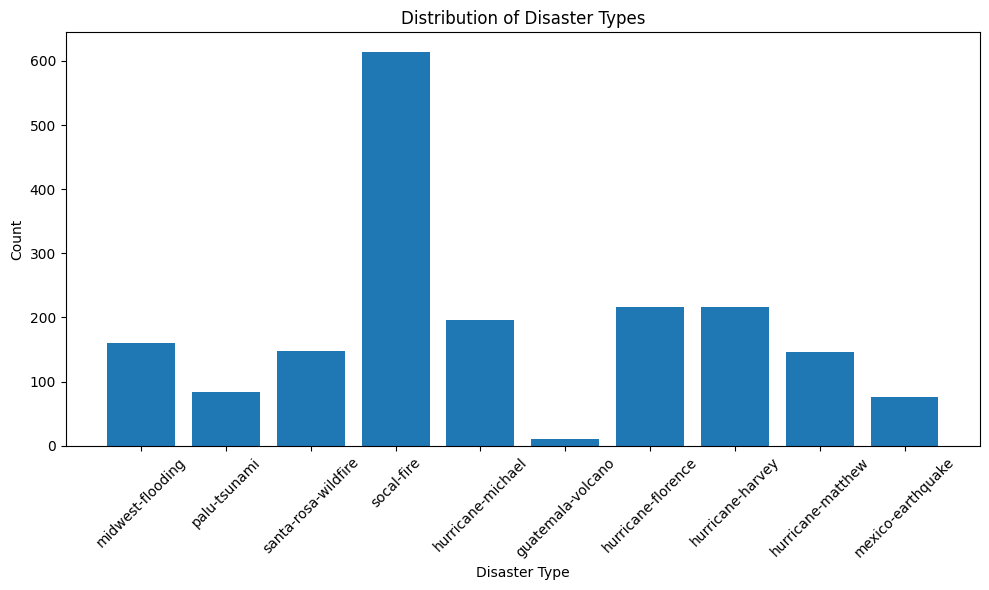

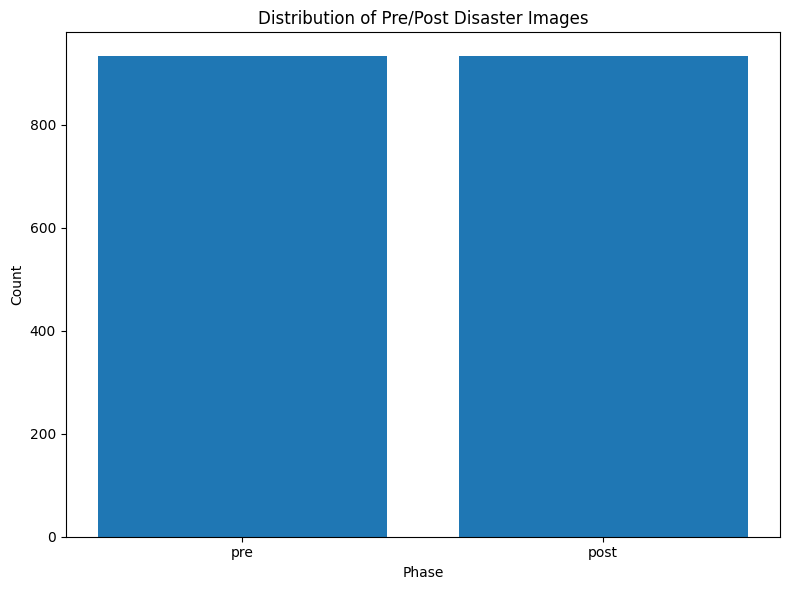

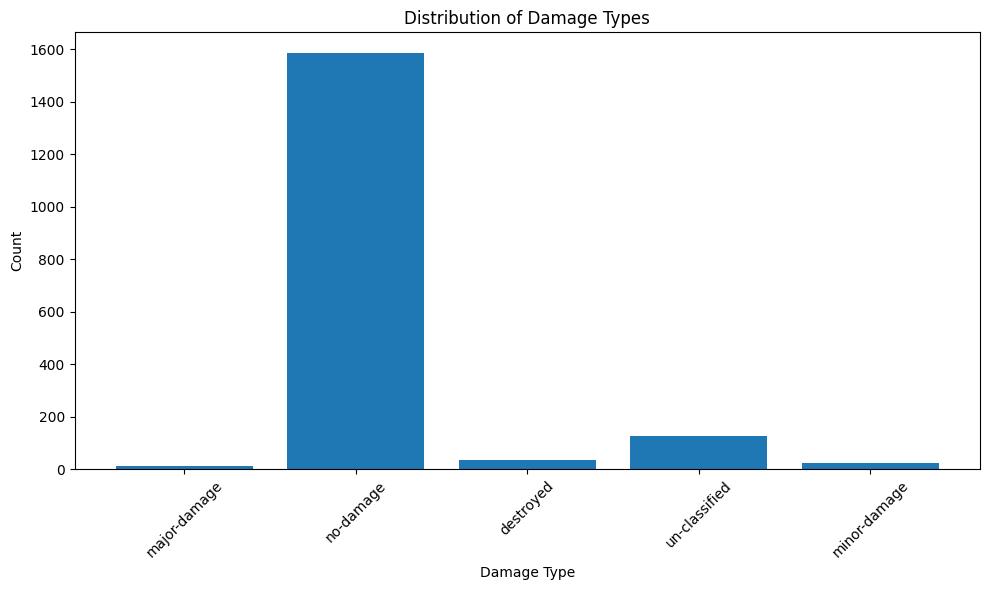

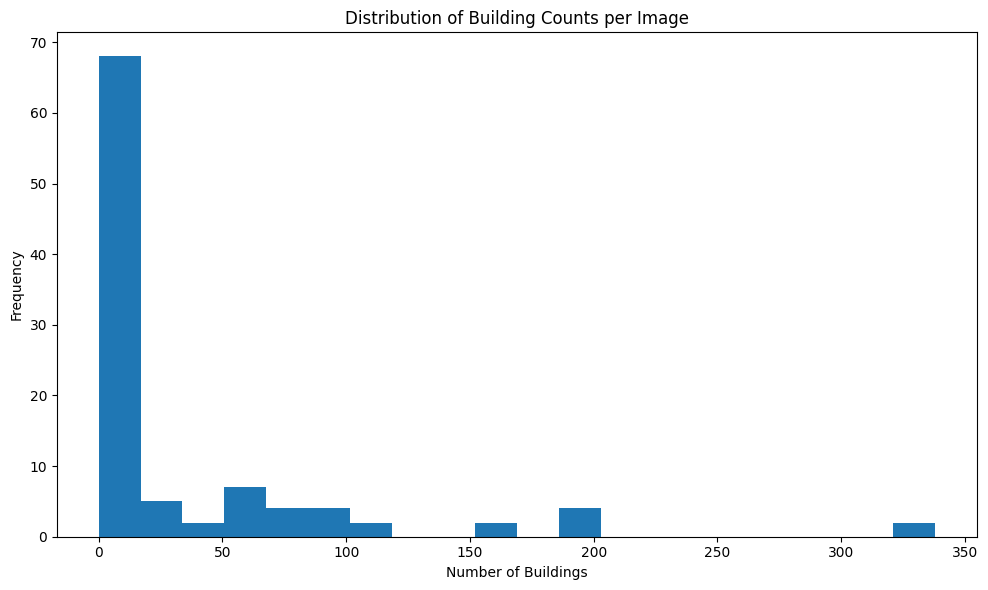

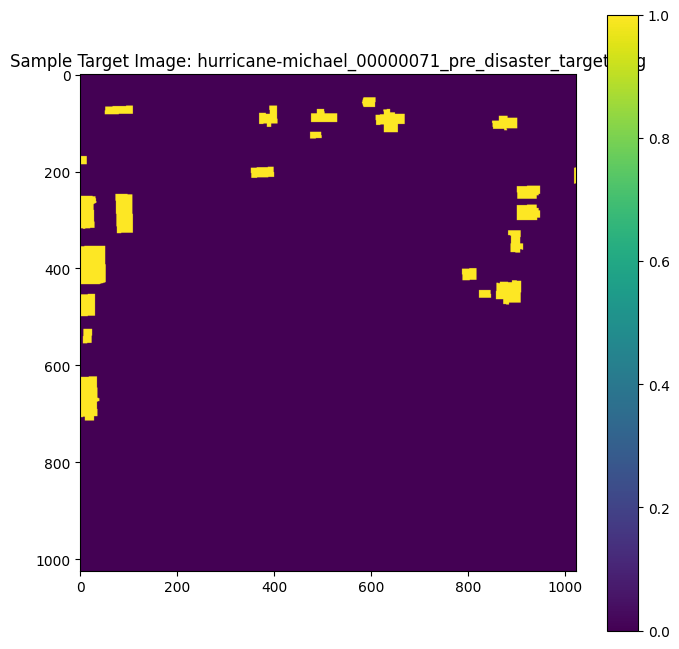

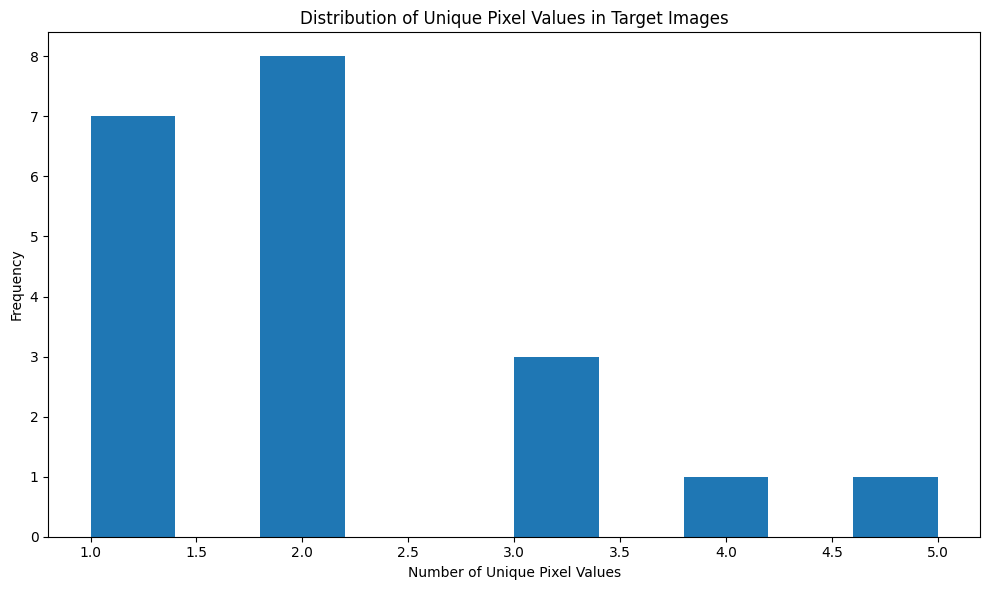

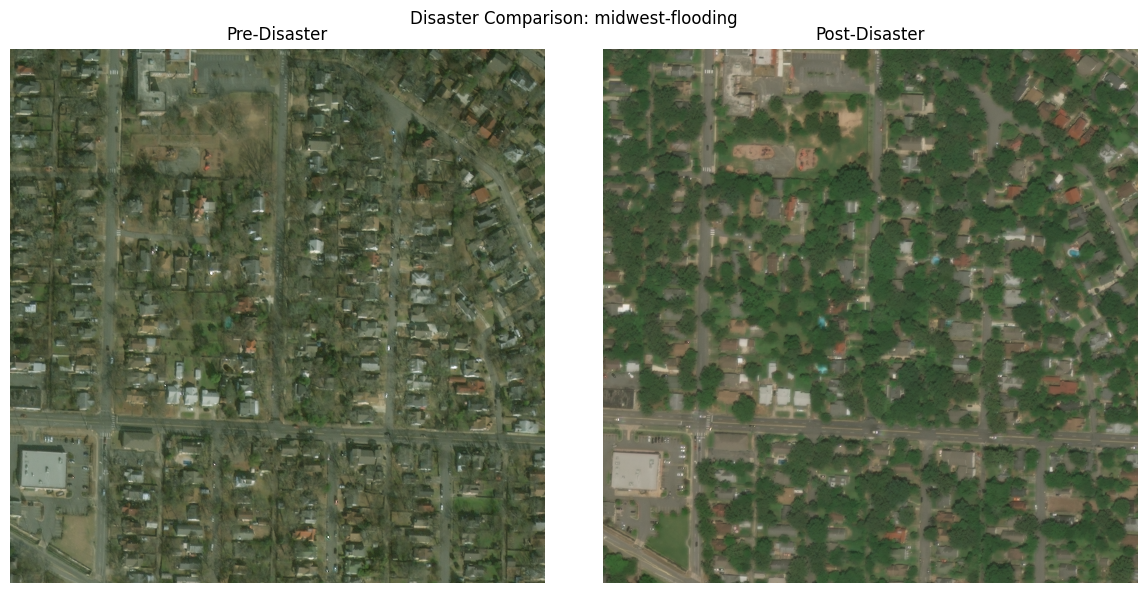

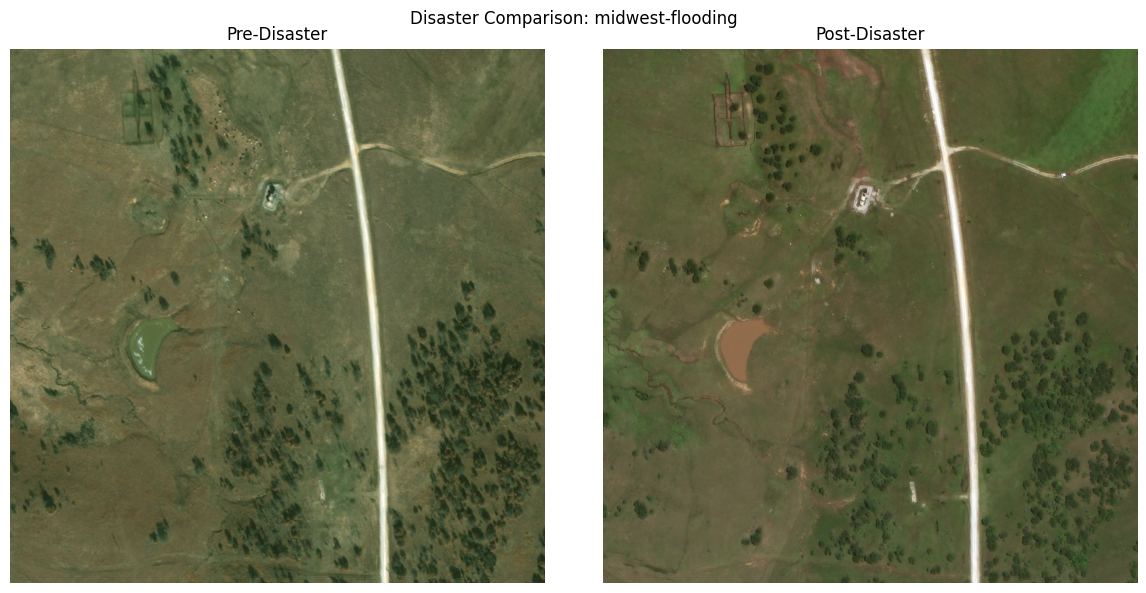

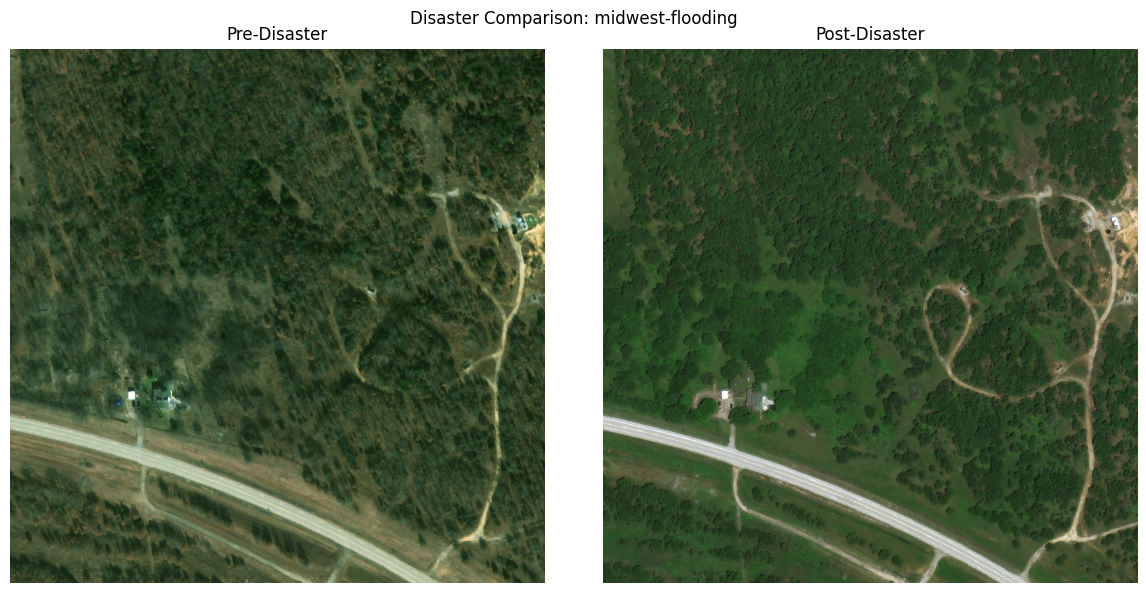

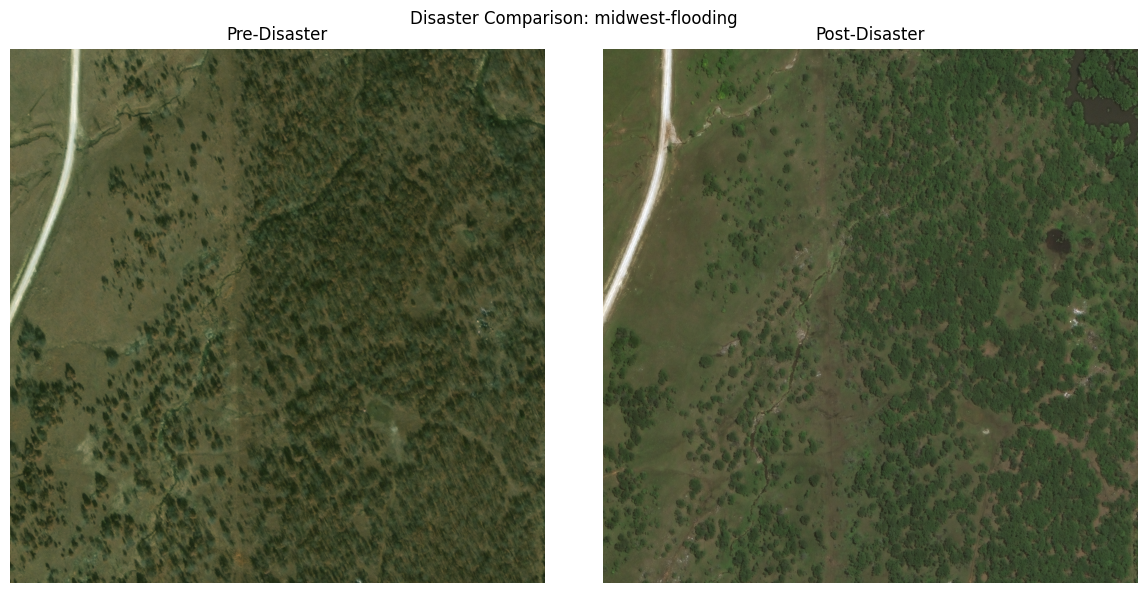

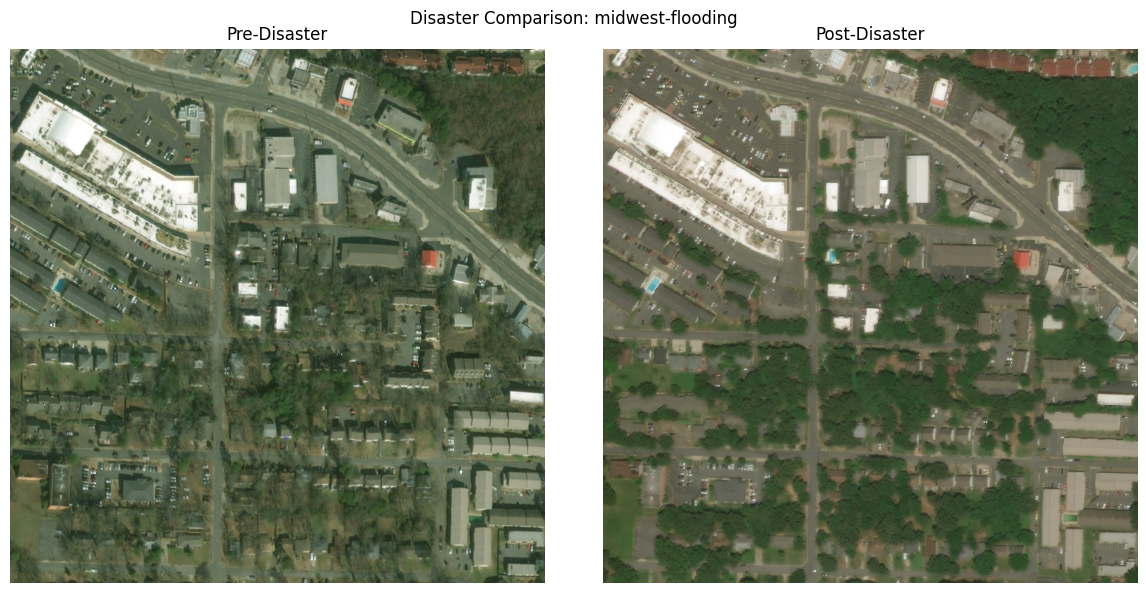

In [11]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from PIL import Image
from collections import Counter

# Define the paths
base_path = "/content/drive/MyDrive/Datasets/test" # Update base_path to the correct location
images_path = os.path.join(base_path, "images")
labels_path = os.path.join(base_path, "labels")
targets_path = os.path.join(base_path, "targets")

# Function to explore and visualize images
def explore_images():
    image_files = os.listdir(images_path)
    print(f"Total number of images: {len(image_files)}")

    # Extract disaster types and pre/post information
    disaster_types = []
    disaster_phases = []

    for img_file in image_files:
        parts = img_file.split('_')
        if len(parts) >= 3:
            disaster_name = parts[0]
            disaster_types.append(disaster_name)

            if 'pre' in img_file:
                disaster_phases.append('pre')
            elif 'post' in img_file:
                disaster_phases.append('post')

    # Count and visualize disaster types
    disaster_counts = Counter(disaster_types)
    plt.figure(figsize=(10, 6))
    plt.bar(disaster_counts.keys(), disaster_counts.values())
    plt.title('Distribution of Disaster Types')
    plt.xlabel('Disaster Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('disaster_types_distribution.png')

    # Count and visualize pre/post phases
    phase_counts = Counter(disaster_phases)
    plt.figure(figsize=(8, 6))
    plt.bar(phase_counts.keys(), phase_counts.values())
    plt.title('Distribution of Pre/Post Disaster Images')
    plt.xlabel('Phase')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig('disaster_phases_distribution.png')

    return disaster_counts, phase_counts

# Function to explore labels (JSON files)
def explore_labels():
    label_files = os.listdir(labels_path)
    print(f"Total number of label files: {len(label_files)}")

    # Analyze label content
    damage_types = []
    building_counts = []
    feature_types = []

    for label_file in label_files[:100]:  # Sample 100 files to avoid long processing
        label_path = os.path.join(labels_path, label_file)
        try:
            with open(label_path, 'r') as f:
                data = json.load(f)

                if 'features' in data and 'lng_lat' in data['features']:
                    features = data['features']['lng_lat']
                    building_counts.append(len(features))

                    for feature in features:
                        if 'properties' in feature:
                            props = feature['properties']
                            feature_types.append(props.get('feature_type', 'unknown'))

                            if 'subtype' in props:
                                damage_types.append(props['subtype'])
        except Exception as e:
            print(f"Error processing {label_file}: {e}")

    # Visualize damage types
    damage_counts = Counter(damage_types)
    plt.figure(figsize=(10, 6))
    plt.bar(damage_counts.keys(), damage_counts.values())
    plt.title('Distribution of Damage Types')
    plt.xlabel('Damage Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('damage_types_distribution.png')

    # Visualize building counts per image
    plt.figure(figsize=(10, 6))
    plt.hist(building_counts, bins=20)
    plt.title('Distribution of Building Counts per Image')
    plt.xlabel('Number of Buildings')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.savefig('building_counts_distribution.png')

    return damage_counts, Counter(feature_types)

# Function to explore targets (PNG files)
def explore_targets():
    target_files = os.listdir(targets_path)
    print(f"Total number of target files: {len(target_files)}")

    # Analyze target images
    target_sizes = []
    unique_pixel_values = []

    for target_file in target_files[:20]:  # Sample 20 files
        target_path = os.path.join(targets_path, target_file)
        try:
            img = Image.open(target_path)
            target_sizes.append(img.size)

            # Convert to numpy array and find unique values
            img_array = np.array(img)
            unique_values = np.unique(img_array)
            unique_pixel_values.append(len(unique_values))

            # Display a sample target image
            if len(unique_pixel_values) == 1:  # Only show the first one
                plt.figure(figsize=(8, 8))
                plt.imshow(img_array)
                plt.title(f'Sample Target Image: {target_file}')
                plt.colorbar()
                plt.savefig('sample_target_image.png')

        except Exception as e:
            print(f"Error processing {target_file}: {e}")

    print(f"Target image sizes: {set(target_sizes)}")
    print(f"Number of unique pixel values: {unique_pixel_values}")

    # Visualize distribution of unique pixel values
    plt.figure(figsize=(10, 6))
    plt.hist(unique_pixel_values, bins=10)
    plt.title('Distribution of Unique Pixel Values in Target Images')
    plt.xlabel('Number of Unique Pixel Values')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.savefig('unique_pixel_values_distribution.png')

# Sample a few images for visual inspection
def visualize_sample_images():
    image_files = os.listdir(images_path)

    # Get pre and post disaster pairs if possible
    pre_images = [img for img in image_files if 'pre' in img]
    post_images = [img for img in image_files if 'post' in img]

    # Try to find matching pairs
    sample_pairs = []
    for pre_img in pre_images[:5]:
        base_name = pre_img.replace('pre', 'post')
        if base_name in post_images:
            sample_pairs.append((pre_img, base_name))

    # Visualize pairs
    for i, (pre_img, post_img) in enumerate(sample_pairs):
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        pre_path = os.path.join(images_path, pre_img)
        post_path = os.path.join(images_path, post_img)

        axes[0].imshow(Image.open(pre_path))
        axes[0].set_title('Pre-Disaster')
        axes[0].axis('off')

        axes[1].imshow(Image.open(post_path))
        axes[1].set_title('Post-Disaster')
        axes[1].axis('off')

        plt.suptitle(f'Disaster Comparison: {pre_img.split("_")[0]}')
        plt.tight_layout()
        plt.savefig(f'disaster_comparison_{i}.png')

# Run the analysis
disaster_counts, phase_counts = explore_images()
damage_counts, feature_types = explore_labels()
explore_targets()
visualize_sample_images()

# Summary statistics
print("\n=== Dataset Summary ===")
print(f"Total images: {len(os.listdir(images_path))}")
print(f"Disaster types: {', '.join(disaster_counts.keys())}")
print(f"Phase distribution: {dict(phase_counts)}")
print(f"Damage types: {', '.join(damage_counts.keys())}")
print(f"Feature types: {dict(feature_types)}")

2️⃣ Prepare the dataset:

In [14]:

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import json
import numpy as np

class DisasterDataset(Dataset):
    def __init__(self, image_dir, label_dir, target_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.target_dir = target_dir
        self.image_filenames = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        # Get image filename
        img_name = self.image_filenames[idx]
        image_path = os.path.join(self.image_dir, img_name)

        # Get corresponding label filename (JSON)
        label_name = img_name.replace('.png', '.json') if img_name.endswith('.png') else img_name + '.json'
        label_path = os.path.join(self.label_dir, label_name)

        # Get corresponding target filename (segmentation mask PNG)
        target_name = img_name.replace('.png', '_target.png') if img_name.endswith('.png') else img_name + '_target.png'
        target_path = os.path.join(self.target_dir, target_name)

        # Load image
        image = Image.open(image_path).convert('RGB')

        # Load label (JSON)
        with open(label_path, 'r') as f:
            label_data = json.load(f)

        # Extract relevant information from label (customize based on what you need)
        # For example, extracting damage types and building locations
        max_buildings = 100  # Define a maximum number of buildings per image

        damage_types = ['unknown'] * max_buildings  # Initialize with placeholder

        if 'features' in label_data and 'lng_lat' in label_data['features']:
            num_buildings = min(len(label_data['features']['lng_lat']), max_buildings)
            for i in range(num_buildings):
                props = label_data['features']['lng_lat'][i].get('properties', {})
                damage_types[i] = props.get('subtype', 'unknown')

        label = damage_types  # Now label is a list of damage types



        # Load target (segmentation mask)
        target = Image.open(target_path)

        # Apply transformations
        if self.transform:
            # If using albumentations
            transformed = self.transform(image=np.array(image), mask=np.array(target))
            image = transformed['image']
            target = transformed['mask']
        else:
            # If using torchvision transforms
            image = transforms.ToTensor()(image)
            target = transforms.ToTensor()(target)

        return image, label, target

# Define the directories
image_dir = '/content/drive/MyDrive/Datasets/test/images'
label_dir = '/content/drive/MyDrive/Datasets/test/labels'
target_dir = '/content/drive/MyDrive/Datasets/test/targets'

# Define transformations if needed
# If using albumentations:
# import albumentations as A
# transform = A.Compose([
#     A.Resize(512, 512),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     A.ToTensorV2(),
# ])

# Create dataset and dataloader
transform = None  # Replace with your transformations
dataset = DisasterDataset(image_dir, label_dir, target_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Testing the dataloader
for i, (images, labels, targets) in enumerate(dataloader):
    if i == 0:
        print(f"Image batch shape: {images.shape}")
        print(f"Target batch shape: {targets.shape}")
        print(f"Number of buildings in first image: {len(labels[0])}")
        break

Image batch shape: torch.Size([8, 3, 1024, 1024])
Target batch shape: torch.Size([8, 1, 1024, 1024])
Number of buildings in first image: 8


Creating dataset...
Found 1866 images in /content/drive/MyDrive/Datasets/test/images
Sample image filenames: ['midwest-flooding_00000050_pre_disaster.png', 'midwest-flooding_00000071_post_disaster.png', 'midwest-flooding_00000088_pre_disaster.png']

Testing first item in dataset...
Image path: /content/drive/MyDrive/Datasets/test/images/midwest-flooding_00000050_pre_disaster.png
Mask path: /content/drive/MyDrive/Datasets/test/targets/midwest-flooding_00000050_pre_disaster_target.png
Image exists: True
Mask exists: True
First image shape: torch.Size([3, 256, 256])
First mask shape: torch.Size([256, 256])


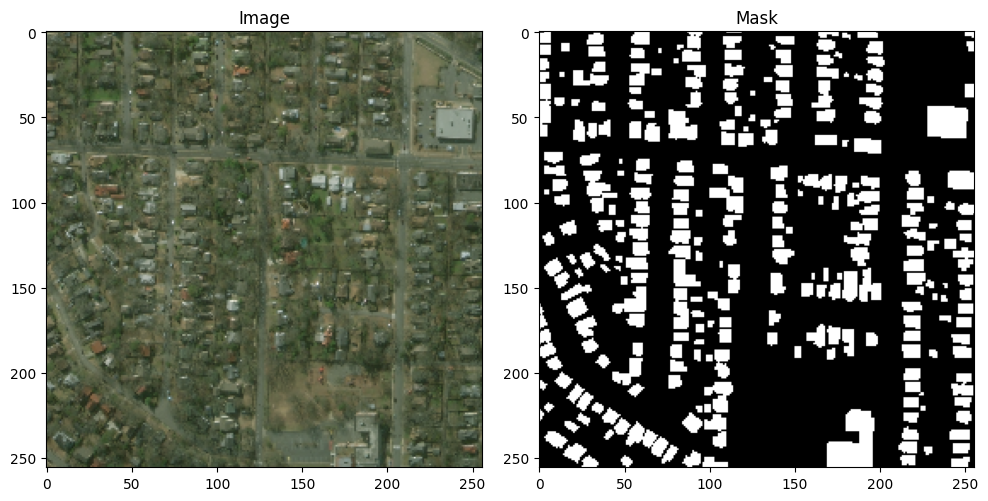


Creating dataloader...

Testing dataloader with first batch...
Batch 1:
Images shape: torch.Size([4, 3, 256, 256])
Masks shape: torch.Size([4, 256, 256])


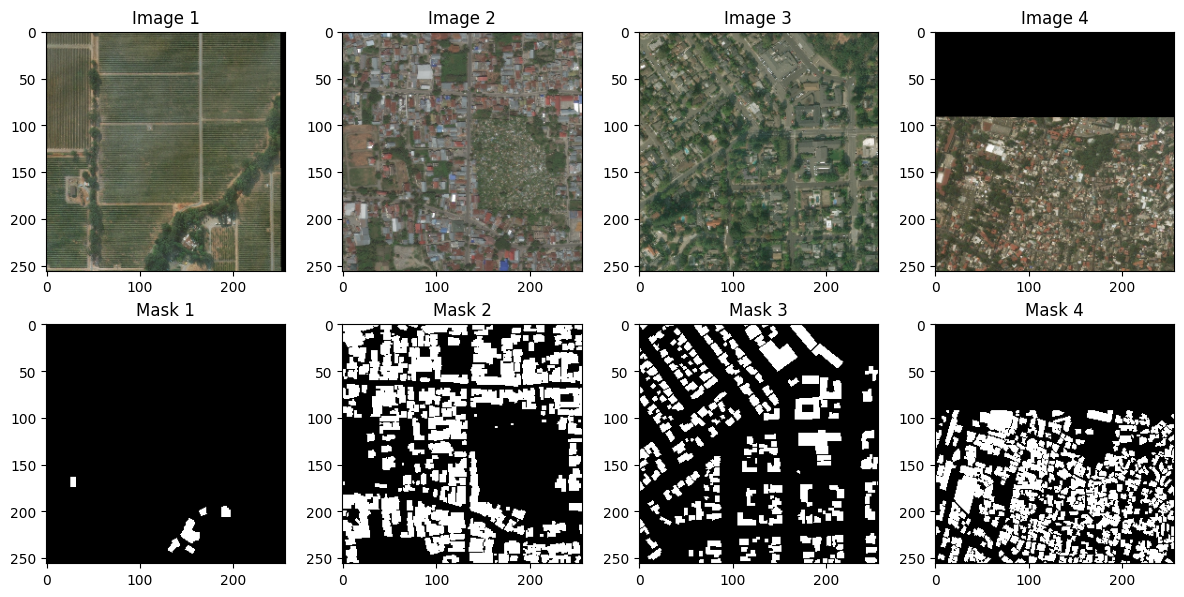

In [17]:
import os
import cv2
import torch
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader

# Directories for images and masks
image_dir = '/content/drive/MyDrive/Datasets/test/images'
mask_dir = '/content/drive/MyDrive/Datasets/test/targets'  # Using targets folder

# Data augmentations
transform = A.Compose([
    A.Resize(height=256, width=256),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

# Dataset class
class xView2Dataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_filenames = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
        self.transform = transform
        print(f"Found {len(self.image_filenames)} images in {image_dir}")

        # Print sample filenames to verify
        print(f"Sample image filenames: {self.image_filenames[:3]}")

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_filename = self.image_filenames[idx]
        img_path = os.path.join(self.image_dir, img_filename)

        # Extract base name without extension to create mask filename
        base_name = os.path.splitext(img_filename)[0]
        mask_filename = f"{base_name}_target.png"
        mask_path = os.path.join(self.mask_dir, mask_filename)

        # Debug info for the first few items
        if idx < 3:
            print(f"Image path: {img_path}")
            print(f"Mask path: {mask_path}")
            print(f"Image exists: {os.path.exists(img_path)}")
            print(f"Mask exists: {os.path.exists(mask_path)}")

        # Load image
        image = cv2.imread(img_path)
        if image is None:
            raise ValueError(f"Could not load image at {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load mask (with error handling)
        try:
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask is None:
                print(f"Warning: Could not load mask at {mask_path}, using empty mask")
                mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
        except Exception as e:
            print(f"Error loading mask {mask_path}: {e}")
            mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)

        # Apply transformations
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]  # Already tensor from ToTensorV2

        return image, mask

# Create dataset and display information
print("Creating dataset...")
train_dataset = xView2Dataset(image_dir, mask_dir, transform=transform)

# Check first item manually
print("\nTesting first item in dataset...")
try:
    image, mask = train_dataset[0]
    print(f"First image shape: {image.shape}")
    print(f"First mask shape: {mask.shape}")

    # Visualize
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)

    # Convert tensor back to numpy for visualization
    img_np = image.permute(1, 2, 0).numpy()
    img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img_np = np.clip(img_np, 0, 1)

    plt.imshow(img_np)
    plt.title("Image")

    plt.subplot(1, 2, 2)
    plt.imshow(mask.squeeze().numpy(), cmap='gray')
    plt.title("Mask")
    plt.tight_layout()
    plt.savefig('sample_image_mask.png')  # Save figure to ensure it's visible
    plt.show()
except Exception as e:
    print(f"Error testing first item: {e}")

# Create DataLoader
print("\nCreating dataloader...")
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Test the dataloader
print("\nTesting dataloader with first batch...")
try:
    for i, (images, masks) in enumerate(train_loader):
        print(f"Batch {i+1}:")
        print(f"Images shape: {images.shape}")
        print(f"Masks shape: {masks.shape}")

        # Display first image and mask in batch
        plt.figure(figsize=(12, 6))
        for j in range(min(4, len(images))):
            plt.subplot(2, 4, j+1)
            img = images[j].permute(1, 2, 0).cpu().numpy()
            img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img = np.clip(img, 0, 1)
            plt.imshow(img)
            plt.title(f"Image {j+1}")

            plt.subplot(2, 4, j+5)
            plt.imshow(masks[j].squeeze().cpu().numpy(), cmap='gray')
            plt.title(f"Mask {j+1}")

        plt.tight_layout()
        plt.savefig('batch_samples.png')  # Save figure to ensure it's visible
        plt.show()

        if i == 0:  # Just show the first batch
            break
except Exception as e:
    print(f"Error testing dataloader: {e}")

## 🏗 Step 3: U-Net Model for Segmentation

In [19]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

def build_small_unet(input_size=(256, 256, 3), n_filters=16):
    """Build a small U-Net model that's memory efficient"""
    inputs = Input(input_size)

    # Contracting path (encoder)
    c1 = Conv2D(n_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(n_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(n_filters*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(n_filters*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(n_filters*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(n_filters*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bridge
    c4 = Conv2D(n_filters*8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(n_filters*8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    c4 = BatchNormalization()(c4)

    # Expansive path (decoder)
    u5 = Conv2DTranspose(n_filters*4, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(n_filters*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u5)
    c5 = BatchNormalization()(c5)
    c5 = Conv2D(n_filters*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    c5 = BatchNormalization()(c5)

    u6 = Conv2DTranspose(n_filters*2, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(n_filters*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Conv2D(n_filters*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    c6 = BatchNormalization()(c6)

    u7 = Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(n_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Conv2D(n_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    c7 = BatchNormalization()(c7)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Define dice coefficient metrics for evaluation
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

# Create and compile the model
model = build_small_unet(input_size=(256, 256, 3), n_filters=16)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=dice_loss,
              metrics=[dice_coef, 'binary_accuracy'])

# Show model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 16)   │            448 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 16)   │             64 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 16)   │          2,320 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 16)   │             64 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 16)   │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 32)   │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 32)   │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 128, 32)   │            128 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 32)     │              0 │ batch_normalization_3… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 64, 64, 64)     │            256 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 64, 64, 64)     │            256 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2      

 Total params: 484,849 (1.85 MB)

 Trainable params: 483,441 (1.84 MB)

 Non-trainable params: 1,408 (5.50 KB)


We will use a pretrained U-Net from segmentation-models-pytorch.

In [ ]:
import torch
import segmentation_models_pytorch as smp
import cv2
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os

# ==========================
# 1. CONFIGURATION
# ==========================
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
MODEL_PATH = "model_epoch_20.pth"  # Path to trained model
ENCODER = 'efficientnet-b4'
ENCODER_WEIGHTS = None
IMG_SIZE = 256
INPUT_DIR = "dataset/test/images/"
OUTPUT_DIR = "dataset/test/predictions/"

# ==========================
# 2. LOAD TRAINED MODEL
# ==========================
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    in_channels=3,
    classes=1
)

model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model = model.to(DEVICE)
model.eval()

# ==========================
# 3. IMAGE PREPROCESSING
# ==========================
transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

# ==========================
# 4. INFERENCE FUNCTION
# ==========================
def predict(image_path, model):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    augmented = transform(image=image)
    image = augmented["image"].unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        output = model(image)
        output = torch.sigmoid(output).cpu().numpy()[0, 0]

    return output

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

for img_name in os.listdir(INPUT_DIR):
    img_path = os.path.join(INPUT_DIR, img_name)
    mask = predict(img_path, model)

    output_path = os.path.join(OUTPUT_DIR, img_name)
    cv2.imwrite(output_path, (mask * 255).astype(np.uint8))

print("✅ Inference completed! Masks saved in:", OUTPUT_DIR)


## 🎨 Step 4: Visualizing Predictions
Now, let's visualize the model's predictions.

In [ ]:
def visualize_predictions(model, dataset, num_samples=3):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.eval()

    fig, axes = plt.subplots(num_samples, 3, figsize=(10, num_samples * 3))

    for i in range(num_samples):
        image, mask = dataset[i]
        image = image.unsqueeze(0).to(device)

        with torch.no_grad():
            pred_mask = torch.sigmoid(model(image))
            pred_mask = (pred_mask.cpu().squeeze().numpy() > 0.5).astype(np.uint8)

        axes[i, 0].imshow(image.cpu().squeeze().permute(1, 2, 0))
        axes[i, 0].set_title("Оригинальное изображение")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(mask.squeeze(), cmap="gray")
        axes[i, 1].set_title("Настоящая маска")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(pred_mask, cmap="gray")
        axes[i, 2].set_title("Предсказанная маска")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

visualize_predictions(model, train_dataset)


## ✅ Final Results
✔️ Trained U-Net model that segments buildings in satellite images

✔️ Visualization of predicted masks

✔️ Optimized pipeline for Google Colab


